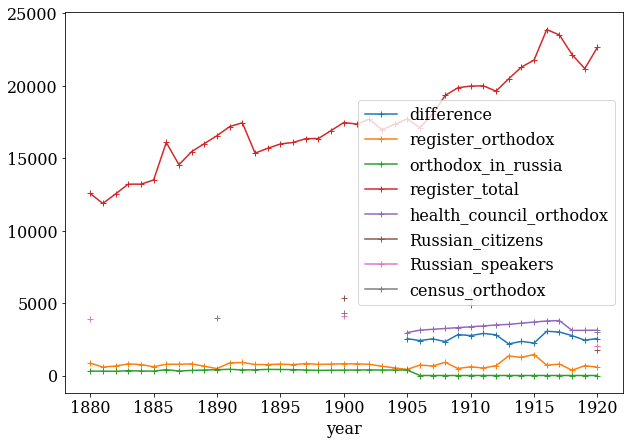

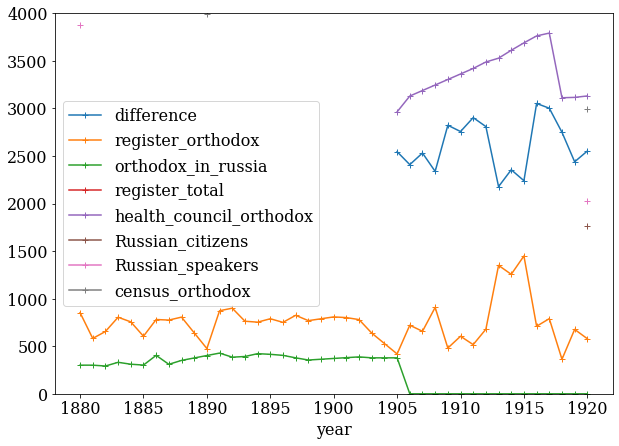

In [16]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = Path('../data')
figure_dir = Path('../figures')
figure_dir.mkdir(exist_ok=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
poll_tax['orthodox'] = poll_tax.orthodox - poll_tax.in_russia_orthodox
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
data = pd.DataFrame([
    difference,
    poll_tax.orthodox,
    poll_tax.in_russia_orthodox,
    poll_tax.total,
    health_council,
    foreigners,
    language,
    religion,
]).T
data.columns = [
    'difference',
    'register_orthodox',
    'orthodox_in_russia',
    'register_total',
    'health_council_orthodox',
    'Russian_citizens',
    'Russian_speakers',
    'census_orthodox',
]
# data.interpolate(method='linear', inplace=True)
data.plot(marker='+', legend=True, figsize=(10, 7))
plt.savefig(figure_dir / 'timeseries1.png')
data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 4000))
plt.savefig(figure_dir / 'timeseries2.png')

## Fourier analysis

No few-year clear cycle detectable

[20.5        13.66666667 10.25        8.2         6.83333333  5.85714286
  5.125       4.55555556  4.1         3.72727273  3.41666667  3.15384615
  2.92857143  2.73333333  2.5625      2.41176471  2.27777778  2.15789474
  2.05      ]


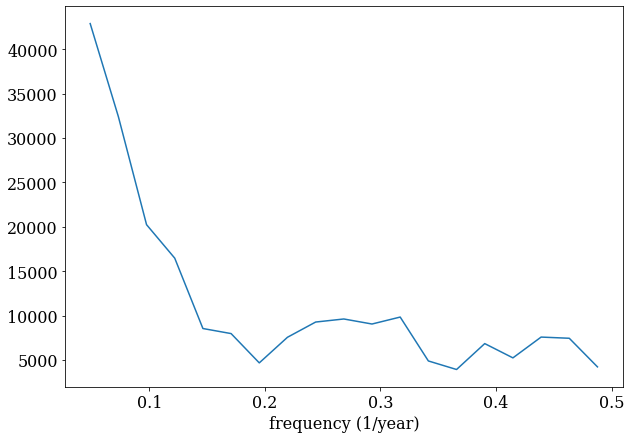

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

ft = np.abs(rfft(data['register_total']))[2:]
freq = rfftfreq(len(data.index))[2:]

plt.figure(figsize=(10, 7))
plt.plot(freq, ft)

plt.xlabel('frequency (1/year)')
# plt.show()
plt.savefig(figure_dir / 'fourier.png')

print(1/freq)

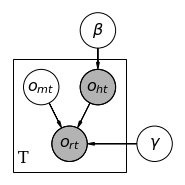

In [18]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

# pgm.add_node('sigma', r'$\sigma_{\beta}$', 1, 3, fixed=True)
# pgm.add_node('mu', r'$\mu_{\beta}$', 2, 4, fixed=True)
pgm.add_node('health_orthodox', r'$o_{ht}$', 2, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('register_orthodox', r'$o_{rt}$', 1.5, 1, fixed=False, scale=scale, observed=True)
pgm.add_node('missing_orthodox', r'$o_{mt}$', 1, 2, fixed=False, scale=scale, observed=False)
pgm.add_node('beta_orthodox_city', r'$\beta$', 2, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('gamma', r'$\gamma$', 3, 1, fixed=False, scale=scale, observed=False)

# pgm.add_edge('sigma', 'beta_orthodox_city', directed=True)
# pgm.add_edge('mu', 'beta_orthodox_city', directed=True)
pgm.add_edge('beta_orthodox_city', 'health_orthodox', directed=True)
pgm.add_edge('gamma', 'register_orthodox', directed=True)
pgm.add_edge('health_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('missing_orthodox', 'register_orthodox', directed=True)

pgm.add_plate([0.5, 0.5, 2, 2], 'T')

pgm.render()

Model:

$ o_{rt} = \gamma o_{ht} - o_{mt} $

$ \gamma \sim N(0.8, 0.1^2) $

$ o_{mt} \sim N(0.5, 0.1^2) $

$ o_{ht} \sim N(\mu_{o_{ht}}, 0.01^2) $

$ \mu_{o_{ht}} = \beta_0 + \beta_1 t $

$ \beta \sim N\begin{pmatrix}\begin{bmatrix} 0.75 \\ 0.02 \end{bmatrix},
 \begin{bmatrix} 0.02 && 0 \\ 0 && 0.002 \end{bmatrix}\end{pmatrix} $

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Convergence achieved at 26100
Interrupted at 26,099 [13%]: Average Loss = 28,960
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_1, beta_0, sigma_total]
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_1, beta_0, sigma_total]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

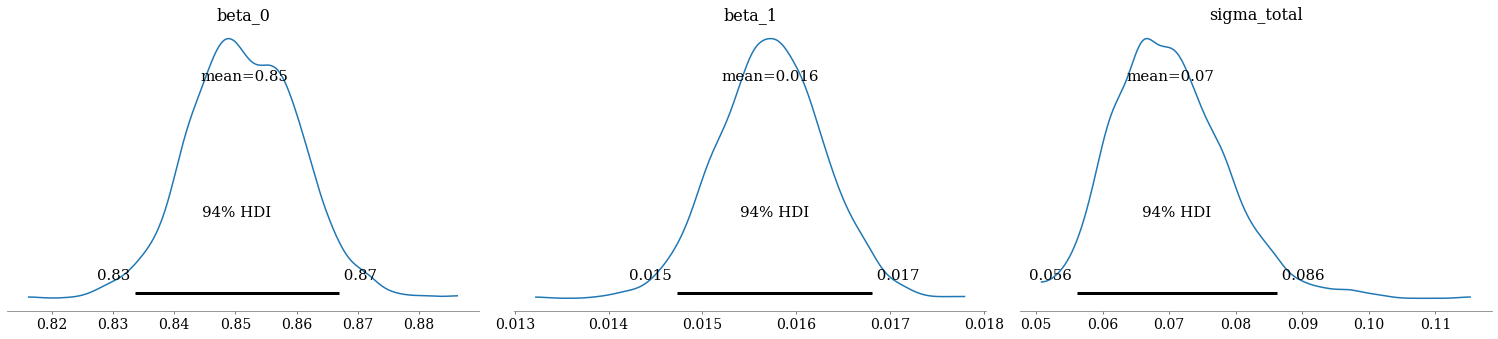

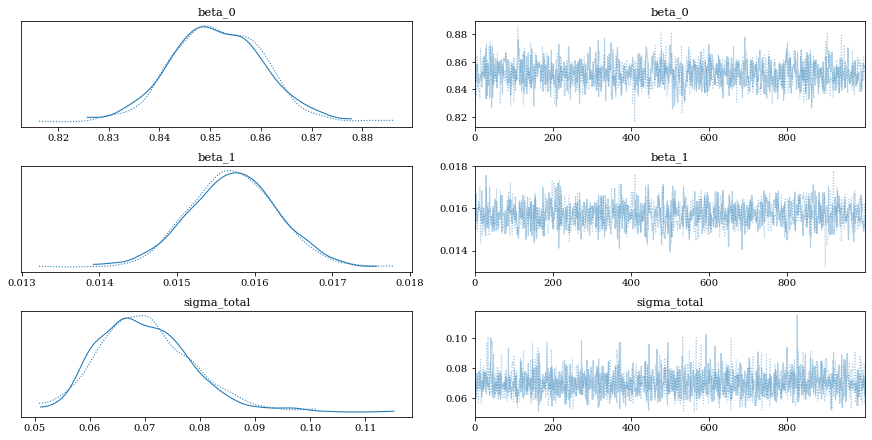

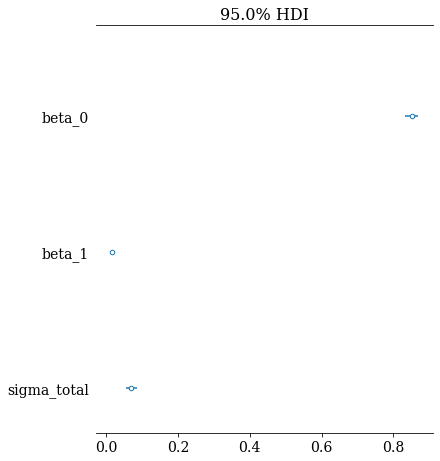

In [19]:
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

data_pm = data.iloc[:-3,]
standard = 15_000
data_pm = data_pm / standard
data_pm['t'] = data_pm.index - 1880

with pm.Model() as model:
    n, _ = data_pm.shape
    sigma_total = pm.Exponential('sigma_total', 1)
    beta_0 = pm.Normal("beta_0", mu=0.85, sigma=0.01)
    beta_1 = pm.Normal("beta_1", mu=0.015, sigma=0.001)
    mu_total = tt.add(beta_0, tt.mul(beta_1, data_pm.t))
    total = pm.Normal(
        'total',
        mu=mu_total,
        sigma=sigma_total,
        observed=data_pm.register_total,
    )

    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

# with pm.Model() as model:
#     n, _ = data_pm.shape
#     beta_0 = pm.Normal("beta_0", mu=0.9, sigma=0.1)
#     beta_1 = pm.Normal("beta_1", mu=0.015, sigma=0.1)
#     idx = np.arange(n-1)
#     cov_e = np.diag(np.repeat(20, n))
#     sigma_total = pm.Exponential("sigma_total", 0.2)
#     mu_total = beta_0 + beta_1 * data_pm.t
#     total = pm.Normal(
#         "total",
#         mu=mu_total,
#         sigma=sigma_total,
#         observed=data_pm.register_total,
#     )
#     trace = pm.sample(1000, tune=2000, init="advi+adapt_diag")
#     prior = pm.sample_prior_predictive()
#     posterior = pm.sample()
#     posterior_pred = pm.sample_posterior_predictive(posterior)

# with pm.Model() as model:
#     pm.glm.GLM.from_formula(
#         'health_council_orthodox ~ t',
#         family=pm.glm.families.Normal(),
#         data=data_pm,
#     )
#     posterior = pm.sample()
#     posterior_pred = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=True, hdi_prob=0.95)

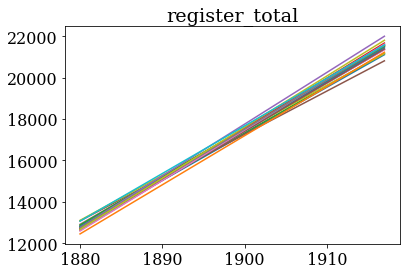

In [20]:
def plot_prediction(data, standard, skip=100):
    year = np.arange(1880, 1918, 1)
    intercept = data['beta_0'][::skip, ] * standard
    t = data['beta_1'][::skip, ] * standard

    for sample in zip(intercept, t):
        total = sample[0] + sample[1] * (year - 1880)
        plt.plot(year, total)
    plt.title('register_total')
    plt.show()

# plot_prediction(prior, standard=standard)
plot_prediction(posterior, standard=standard)

year
1880   -0.002333
1881   -0.064533
1882   -0.036533
1883   -0.007467
1884   -0.023467
1885   -0.020467
1886    0.136333
1887    0.017800
1888    0.062200
1889    0.082967
1890    0.103733
1891    0.129533
1892    0.130867
1893   -0.024800
1894   -0.018467
1895   -0.014600
1896   -0.023667
1897   -0.022133
1898   -0.037533
1899   -0.016700
1900    0.004133
1901   -0.018933
1902   -0.012933
1903   -0.076867
1904   -0.068400
1905   -0.059933
1906   -0.115267
1907   -0.069267
1908    0.001000
1909    0.020267
1910    0.011800
1911   -0.003000
1912   -0.043533
1913   -0.002667
1914    0.035000
1915    0.051333
1916    0.175733
1917    0.135133
Name: total_residual, dtype: float64


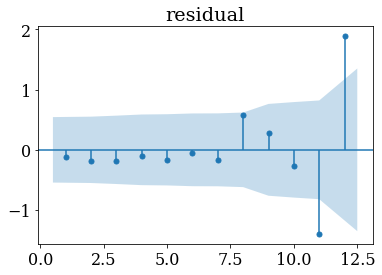

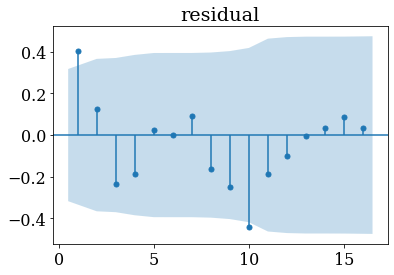

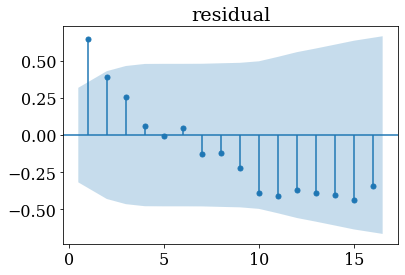

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

data_pm['total_residual'] = data_pm.register_total - (data_pm.t * 0.016 + 0.84)
data_pm['orthodox_residual'] = data_pm.register_orthodox - (data_pm.t * 0.0003 + 0.045)
data_pm['health_council_orthodox_residual'] = data_pm.health_council_orthodox - (data_pm.t * 0.0043 + 0.09)
plot_acf(data_pm.health_council_orthodox_residual[-13:], title='residual', adjusted=True, zero=False)
plot_acf(data_pm.orthodox_residual, title='residual', adjusted=True, zero=False)
plot_acf(data_pm.total_residual, title='residual', adjusted=True, zero=False)
print(data_pm.total_residual)